In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Checking for GPU
!nvidia-smi

Fri Mar 10 07:08:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import zipfile

# Unzip the dataset file
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Datas/Crop dataset.zip")
zip_ref.extractall()
zip_ref.close()

In [ ]:
# Check of how many images in each folder?
import os

# Walk through files
for dirpath, dirnames, filenames in os.walk("Crop dataset"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'Crop dataset'.
There are 31 directories and 0 images in 'Crop dataset/train'.
There are 0 directories and 500 images in 'Crop dataset/train/Grape Black Rot'.
There are 0 directories and 500 images in 'Crop dataset/train/Apple Scab'.
There are 0 directories and 500 images in 'Crop dataset/train/Orange Haunglongbing (Citrus Greening)'.
There are 0 directories and 500 images in 'Crop dataset/train/Tomato Early Blight'.
There are 0 directories and 500 images in 'Crop dataset/train/Peach Bacterial Spot'.
There are 0 directories and 500 images in 'Crop dataset/train/Tomato Septoria Leaf Spot'.
There are 0 directories and 500 images in 'Crop dataset/train/Tomato Leaf Mold'.
There are 0 directories and 500 images in 'Crop dataset/train/Corn Common Rust'.
There are 0 directories and 500 images in 'Crop dataset/train/Potato Late Blight'.
There are 0 directories and 500 images in 'Crop dataset/train/Corn Northern Leaf Blight'.
There are 0 directories and 5

In [ ]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (256, 256)
BATCH_SIZE = 32

train_dir = "Crop dataset/train/"
test_dir = "Crop dataset/test/"

train_datagen = ImageDataGenerator(rescale=1/255.,
                                   rotation_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training Images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing Images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training Images:
Found 15500 images belonging to 31 classes.
Testing Images:
Found 36395 images belonging to 31 classes.


In [ ]:
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [ ]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [ ]:
# Lets make a create model() function to create a model from the URL
def create_model(model_url, num_classes=31):
  """
  Takes a Tensorflow Hub URL and creates Keras Sequential model with it.

  Args:
    model_url (str) : A Tensorflow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10
    Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
      layer and Dense output layer with num_classes output neurons.
    """
  # Download the pretrained model and save it as keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,))
  
  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model

In [ ]:
# Create EfficientNetB0 feature extraction model
efficientnet_model = create_model(model_url=efficientnet_url,
                                  num_classes=train_data.num_classes)

# Compile Efficient net model
efficientnet_model.compile(loss="categorical_crossentropy",
                           optimizer=tf.keras.optimizers.Adam(),
                           metrics=["accuracy"])

# Fit the EfficientNet model to 10% of training data
efficientnet_history = efficientnet_model.fit(train_data,
                                              epochs=5,
                                              steps_per_epoch=len(train_data),
                                              validation_data=test_data,
                                              validation_steps=len(test_data))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Epoch 1/5
485/485 [==============================] - 382s 748ms/step - loss: 0.9009 - accuracy: 0.8072 - val_loss: 0.3837 - val_accuracy: 0.9085
Epoch 2/5
485/485 [==============================] - 357s 736ms/step - loss: 0.3126 - accuracy: 0.9232 - val_loss: 0.2368 - val_accuracy: 0.9422
Epoch 3/5
485/485 [==============================] - 347s 716ms/step - loss: 0.2252 - accuracy: 0.9442 - val_loss: 0.1932 - val_accuracy: 0.9501
Epoch 4/5
485/485 [==============================] - 350s 722ms/step - loss: 0.1827 - accuracy: 0.9520 - val_loss: 0.1478 - val_accuracy: 0.9635
Epoch 5/5
485/485 [==============================] - 355s 732ms/step - loss: 0.1506 - accuracy: 0.9612 - val_loss: 0.1538 - val_accuracy: 0.9566


In [ ]:
# Let's create a function to plot our loss curves
# You could put a function like this into a script called "helper.py" and import it whenever needed
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns seperate loss curves for training and validation metrics.

  Args:
    history: Tensorflow History object.
  
  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]
  
  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

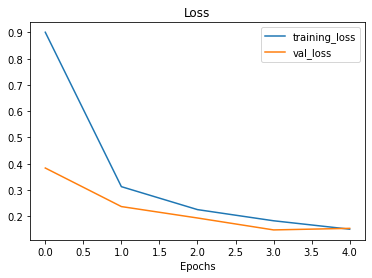

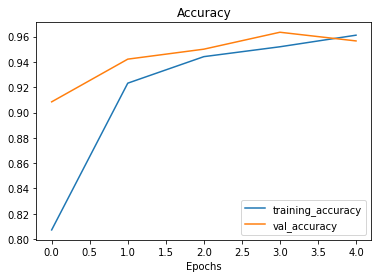

In [ ]:
plot_loss_curves(efficientnet_history)

In [ ]:
efficientnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 31)                39711     
                                                                 
Total params: 4,089,275
Trainable params: 39,711
Non-trainable params: 4,049,564
_________________________________________________________________


In [ ]:
# How many layers does our efficientnet_model has
len(efficientnet_model.layers[0].weights)

309

In [ ]:
# Saving the model
efficientnet_model.save("Trained crop model.h5")